# The sneakers classification problem -- supervised learning

---

## 1. Introduction

This notebook trains and evaluate supervised models to solve the "Popular Sneakers Classification" task.


The following code block contains the main parameters for this notebook.

In [16]:
# Data directory
data_dir = "./data"

# Model parameters
samples_per_class_list = [1, 8, 32, 150] # 150 => all training samples
n_versions = 3
max_steps = 120 * 30
add_from_scratch_models = True
add_ImgNet_pretrained_models = True

---
## 2. Setting up the dataset

We will use the Sneakers data module to automatically download and handle the dataset.

In [ ]:
from dataset_sneakers import SneakersDataModule

datamodule = SneakersDataModule(data_dir=data_dir)

class_names = datamodule.full_dataset.classes

print(datamodule)

{Train dataloader: size=3810}
{Validation dataloader: size=953}
{Test dataloader: size=1190}
{Predict dataloader: None}


---
## 3. Setting up the models



Let's start by writing the code to support the creation of the backbone, the prediction head, and the supervised model itself.

In [18]:
import torch
from torchvision.models import resnet50
from minerva.models.nets.base import SimpleSupervisedModel
from torchmetrics import Accuracy

def generate_backbone(weights=None):
    backbone = resnet50(weights=weights)
    backbone.fc = torch.nn.Identity()
    return backbone

def generate_pred_head(backbone_out_dim=2048, hidden_dim=512):
    return torch.nn.Sequential(
        torch.nn.Linear(backbone_out_dim, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, len(class_names))
    )

# Build a simple supervised model for STL10 using a given backbone
def build_SimpleSupervisedModel(backbone):
  return SimpleSupervisedModel(
    backbone=backbone,
    fc=generate_pred_head(),
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    val_metrics  ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    test_metrics ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
  )

Let's also create a transform pipeline to generate modified training samples.

In [19]:
import torch
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Normalize, RandomResizedCrop, RandomHorizontalFlip, ColorJitter

precomputed_dataset_stats = {'mean': torch.tensor([0.7268, 0.7133, 0.7056]), 
                             'std': torch.tensor([0.3064, 0.3112, 0.3173])}

# Set the training set image transformation pipeline
train_transform_pipeline = Compose([ToImage(),
                                    ToDtype(torch.float32, scale=True),
                                    RandomResizedCrop((128,128), scale=(0.8, 1.0)),
                                    RandomHorizontalFlip(),
                                    ColorJitter(brightness=0.1, contrast=0.1),
                                    Normalize(precomputed_dataset_stats["mean"],
                                              precomputed_dataset_stats["std"])])

Now, let's create models with different configurations (e.g., initial parameters), and models to be trained with different number of samples per class.

In [ ]:
models = {}

from torchvision.models import ResNet50_Weights
import lightning

# Let's set the seeds for reproducibility
lightning.seed_everything(1969)

for version in range(n_versions):

    for train_transform_id, train_transform_pipeline in [ ("aug", train_transform_pipeline), ("notr", None) ]:

        for samples_per_class in samples_per_class_list:

            # -- Add the from scratch model --
            if add_from_scratch_models:
                backbone = generate_backbone()
                models[f"From_Scratch-{train_transform_id}/{samples_per_class}_spc/{max_steps}_steps/v_{version}"] = {
                    "backbone": backbone,
                    "model": build_SimpleSupervisedModel(backbone),
                    "max_steps": max_steps,
                    "samples per class": samples_per_class,
                    "train_transform": train_transform_pipeline,
                    "version": version
                }

            # -- Add the pretrained model: ImageNet weights --
            if add_ImgNet_pretrained_models:
                backbone = generate_backbone(weights=ResNet50_Weights.DEFAULT)
                models[f"Pretrained_ImageNet-{train_transform_id}/{samples_per_class}_spc/{max_steps}_steps/v_{version}"] = {
                    "backbone": backbone,
                    "model": build_SimpleSupervisedModel(backbone),
                    "max_steps": max_steps,
                    "samples per class": samples_per_class,
                    "train_transform": train_transform_pipeline,
                    "version": version
                }

print("== The following models were included ==")
for i, k in enumerate(models.keys()):
    print(f"{i:3d} {k}")

Seed set to 1969


== The following models were included ==
  0 From_Scratch-aug/1_spc/3600_steps/v_0
  1 Pretrained_ImageNet-aug/1_spc/3600_steps/v_0
  2 From_Scratch-aug/8_spc/3600_steps/v_0
  3 Pretrained_ImageNet-aug/8_spc/3600_steps/v_0
  4 From_Scratch-aug/32_spc/3600_steps/v_0
  5 Pretrained_ImageNet-aug/32_spc/3600_steps/v_0
  6 From_Scratch-aug/150_spc/3600_steps/v_0
  7 Pretrained_ImageNet-aug/150_spc/3600_steps/v_0
  8 From_Scratch-aug/1_spc/3600_steps/v_1
  9 Pretrained_ImageNet-aug/1_spc/3600_steps/v_1
 10 From_Scratch-aug/8_spc/3600_steps/v_1
 11 Pretrained_ImageNet-aug/8_spc/3600_steps/v_1
 12 From_Scratch-aug/32_spc/3600_steps/v_1
 13 Pretrained_ImageNet-aug/32_spc/3600_steps/v_1
 14 From_Scratch-aug/150_spc/3600_steps/v_1
 15 Pretrained_ImageNet-aug/150_spc/3600_steps/v_1
 16 From_Scratch-aug/1_spc/3600_steps/v_2
 17 Pretrained_ImageNet-aug/1_spc/3600_steps/v_2
 18 From_Scratch-aug/8_spc/3600_steps/v_2
 19 Pretrained_ImageNet-aug/8_spc/3600_steps/v_2
 20 From_Scratch-aug/32_spc/3600_step

--- 

## 4. Training the models

In [ ]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Register stats
from timeit import default_timer as timer
n_configs = len(models)
n_configs_trained = 0
start_time = timer()

for model_name, model_info in models.items():
    print("***********************************")
    print(f" Training model {model_name}")
    print("***********************************")
    loggers = [TensorBoardLogger(save_dir=f"logs/SneakersDataset/Downstream/", name=model_name),
               CSVLogger(save_dir=f"logs/SneakersDataset/Downstream/", name=model_name)]
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
    trainer = Trainer(max_steps=model_info["max_steps"], benchmark=True, 
                      log_every_n_steps=8, logger=loggers,
                      callbacks=[checkpoint_callback])
    
    # Train the model
    trainer.fit(model_info["model"], 
                train_dataloaders=datamodule.train_dataloader(samples_per_class=model_info["samples per class"], 
                                                              transform=model_info["train_transform"]),
                val_dataloaders=datamodule.val_dataloader())

    # Load parameters from best epoch
    print(f"Loading weights from {checkpoint_callback.best_model_path}")
    best_model = SimpleSupervisedModel.load_from_checkpoint(checkpoint_callback.best_model_path,
                                                            backbone=model_info["model"].backbone,
                                                            fc=model_info["model"].fc,
                                                            loss_fn=torch.nn.CrossEntropyLoss(),
                                                            train_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
                                                            val_metrics  ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
                                                            test_metrics ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))})

    # Test the model
    trainer.test(best_model, dataloaders=datamodule.test_dataloader())

    # Compute and display training statistics
    elapsed = timer() - start_time
    n_configs_trained += 1
    avg = elapsed / n_configs_trained  
    print("-----------------------------------")
    print(f"Training stats")
    print(f"  - Avg time to train models: {avg:.2f} seconds ")
    est_total = avg * n_configs
    est_remaining = est_total - elapsed
    print(f"  - Total # models  : {n_configs} model(s)")
    print(f"  - Models trained  : {n_configs_trained} model(s) in {elapsed:.2f} seconds")
    print(f"  - Remaining models: {n_configs-n_configs_trained} model(s). {est_remaining} s remaining (Estimative)")
    print(f"  - Total time      : {est_total} seconds (estimate: avg * # models)")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


***********************************
 Training model Pretrained_ImageNet/1_spc/2400_steps/v_0
***********************************


You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=8). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.72it/s, v_num=0_1, val_loss=6.800, val_accuracy=0.0336, train_loss=2.41e-6, train_accuracy=1.000]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, v_num=0_1, val_loss=6.800, val_accuracy=0.0336, train_loss=2.41e-6, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/1_spc/2400_steps/v_0/version_0/checkpoints/epoch=1-step=4.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 59.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.03361344709992409    │
│         test_loss         │     3.911907196044922     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 1355.90 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 1 model(s) in 1355.90 seconds
  - Remaining models: 11 model(s). 14914.855415094644 s remaining (Estimative)
  - Total time      : 16270.75136192143 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/8_spc/2400_steps/v_0
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00, 11.26it/s, v_num=0_1, val_loss=5.240, val_accuracy=0.222, train_loss=5.5e-6, train_accuracy=1.000]  

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00, 11.13it/s, v_num=0_1, val_loss=5.240, val_accuracy=0.222, train_loss=5.5e-6, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/8_spc/2400_steps/v_0/version_0/checkpoints/epoch=1-step=26.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 75.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.10000000149011612    │
│         test_loss         │     3.967010259628296     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 844.65 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 2 model(s) in 1689.31 seconds
  - Remaining models: 10 model(s). 8446.534345638938 s remaining (Estimative)
  - Total time      : 10135.841214766726 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/32_spc/2400_steps/v_0
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 11.85it/s, v_num=0_1, val_loss=3.230, val_accuracy=0.406, train_loss=0.156, train_accuracy=0.961] 

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 11.82it/s, v_num=0_1, val_loss=3.230, val_accuracy=0.406, train_loss=0.156, train_accuracy=0.961]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/32_spc/2400_steps/v_0/version_0/checkpoints/epoch=4-step=250.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 68.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.451260507106781     │
│         test_loss         │     2.079331636428833     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 634.33 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 3 model(s) in 1903.00 seconds
  - Remaining models: 9 model(s). 5709.011095389258 s remaining (Estimative)
  - Total time      : 7612.014793852344 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/150_spc/2400_steps/v_0
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 13.63it/s, v_num=0_1, val_loss=2.040, val_accuracy=0.608, train_loss=0.0795, train_accuracy=0.978]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 13.62it/s, v_num=0_1, val_loss=2.040, val_accuracy=0.608, train_loss=0.0795, train_accuracy=0.978]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/150_spc/2400_steps/v_0/version_0/checkpoints/epoch=2-step=360.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 65.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5386554598808289     │
│         test_loss         │     1.691677212715149     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 522.93 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 4 model(s) in 2091.74 seconds
  - Remaining models: 8 model(s). 4183.4722602898255 s remaining (Estimative)
  - Total time      : 6275.208390434738 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/1_spc/2400_steps/v_1
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s, v_num=0_1, val_loss=5.040, val_accuracy=0.0619, train_loss=3.77e-7, train_accuracy=1.000]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s, v_num=0_1, val_loss=5.040, val_accuracy=0.0619, train_loss=3.77e-7, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/1_spc/2400_steps/v_1/version_0/checkpoints/epoch=1-step=4.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 64.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.03361344709992409    │
│         test_loss         │    3.9060821533203125     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 723.74 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 5 model(s) in 3618.72 seconds
  - Remaining models: 7 model(s). 5066.206503565238 s remaining (Estimative)
  - Total time      : 8684.925434683264 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/8_spc/2400_steps/v_1
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00, 12.54it/s, v_num=0_1, val_loss=5.420, val_accuracy=0.167, train_loss=5.5e-5, train_accuracy=1.000]   

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00, 12.40it/s, v_num=0_1, val_loss=5.420, val_accuracy=0.167, train_loss=5.5e-5, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/8_spc/2400_steps/v_1/version_0/checkpoints/epoch=2-step=39.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 72.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.14705882966518402    │
│         test_loss         │    3.6936933994293213     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 664.45 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 6 model(s) in 3986.72 seconds
  - Remaining models: 6 model(s). 3986.7224642420188 s remaining (Estimative)
  - Total time      : 7973.4449284840375 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/32_spc/2400_steps/v_1
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 12.18it/s, v_num=0_1, val_loss=2.860, val_accuracy=0.483, train_loss=0.0107, train_accuracy=0.996]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 12.17it/s, v_num=0_1, val_loss=2.860, val_accuracy=0.483, train_loss=0.0107, train_accuracy=0.996]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/32_spc/2400_steps/v_1/version_0/checkpoints/epoch=3-step=200.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 71.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3739495873451233     │
│         test_loss         │    2.4282419681549072     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 600.30 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 7 model(s) in 4202.07 seconds
  - Remaining models: 5 model(s). 3001.480796497781 s remaining (Estimative)
  - Total time      : 7203.553911594674 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/150_spc/2400_steps/v_1
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 13.56it/s, v_num=0_1, val_loss=2.380, val_accuracy=0.584, train_loss=0.157, train_accuracy=0.956] 

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 13.55it/s, v_num=0_1, val_loss=2.380, val_accuracy=0.584, train_loss=0.157, train_accuracy=0.956]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/150_spc/2400_steps/v_1/version_0/checkpoints/epoch=2-step=360.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 69.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5411764979362488     │
│         test_loss         │    1.7124310731887817     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 548.63 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 8 model(s) in 4389.06 seconds
  - Remaining models: 4 model(s). 2194.5295356640127 s remaining (Estimative)
  - Total time      : 6583.588606992038 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/1_spc/2400_steps/v_2
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, v_num=0_1, val_loss=7.300, val_accuracy=0.0451, train_loss=4.58e-6, train_accuracy=1.000]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 1199: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, v_num=0_1, val_loss=7.300, val_accuracy=0.0451, train_loss=4.58e-6, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/1_spc/2400_steps/v_2/version_0/checkpoints/epoch=1-step=4.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 69.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │   0.038655463606119156    │
│         test_loss         │    3.8867852687835693     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 675.73 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 9 model(s) in 6081.53 seconds
  - Remaining models: 3 model(s). 2027.177243940222 s remaining (Estimative)
  - Total time      : 8108.708975760887 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/8_spc/2400_steps/v_2
***********************************


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00, 10.08it/s, v_num=0_1, val_loss=5.260, val_accuracy=0.206, train_loss=8.22e-6, train_accuracy=1.000]  

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 184:  62%|██████▏   | 8/13 [00:00<00:00,  9.96it/s, v_num=0_1, val_loss=5.260, val_accuracy=0.206, train_loss=8.22e-6, train_accuracy=1.000]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/8_spc/2400_steps/v_2/version_0/checkpoints/epoch=2-step=39.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 69.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.13697479665279388    │
│         test_loss         │     3.666961908340454     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 647.01 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 10 model(s) in 6470.09 seconds
  - Remaining models: 2 model(s). 1294.0187850469729 s remaining (Estimative)
  - Total time      : 7764.112710281835 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/32_spc/2400_steps/v_2
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 11.16it/s, v_num=0_1, val_loss=2.540, val_accuracy=0.526, train_loss=0.00246, train_accuracy=0.998]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 11.14it/s, v_num=0_1, val_loss=2.540, val_accuracy=0.526, train_loss=0.00246, train_accuracy=0.998]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/32_spc/2400_steps/v_2/version_0/checkpoints/epoch=28-step=1450.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 64.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5605041980743408     │
│         test_loss         │     2.203355073928833     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


-----------------------------------
Training stats
  - Avg time to train models: 609.44 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 11 model(s) in 6703.80 seconds
  - Remaining models: 1 model(s). 609.4360732759178 s remaining (Estimative)
  - Total time      : 7313.2328793110155 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/150_spc/2400_steps/v_2
***********************************


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 23.5 M | train
1 | fc       | Sequential       | 1.1 M  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.331    Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 14.05it/s, v_num=0_1, val_loss=2.010, val_accuracy=0.602, train_loss=0.104, train_accuracy=0.971]

`Trainer.fit` stopped: `max_steps=2400` reached.


Epoch 19: 100%|██████████| 120/120 [00:08<00:00, 14.04it/s, v_num=0_1, val_loss=2.010, val_accuracy=0.602, train_loss=0.104, train_accuracy=0.971]
Loading weights from logs/SneakersDataset/Downstream/Pretrained_ImageNet/150_spc/2400_steps/v_2/version_0/checkpoints/epoch=5-step=720.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 38/38 [00:00<00:00, 63.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6218487620353699     │
│         test_loss         │    1.5264716148376465     │
└───────────────────────────┴───────────────────────────┘

-----------------------------------
Training stats
  - Avg time to train models: 574.81 seconds 
  - Total # models  : 12 model(s)
  - Models trained  : 12 model(s) in 6897.66 seconds
  - Remaining models: 0 model(s). 0.0 s remaining (Estimative)
  - Total time      : 6897.6605157628655 seconds (estimate: avg * # models)


--- 
## 5. Plotting the results

In [7]:
import matplotlib.pyplot as plt
import csv

def parse_metrics(metrics_csv_filename):
    metrics = None
    with open(metrics_csv_filename, newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for row in csv_reader:
            if not metrics:
                metrics = { m:[] for m in row }
            else:
                for i, (k,v) in enumerate(metrics.items()):
                    if row[i] != "":
                        if i >= 2:
                            # Add epoch, step, metric_info
                            v.append( (int(row[0]), int(row[1]), float(row[i])) )
                        else:
                            # Add epoch or step info
                            v.append( int(row[i]) )
    return metrics

def plot_results(sorted_list, stats):
    color_array = [ 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    N = len(sorted_list)
    fig, ax = plt.subplots(1, N, figsize=(N*5, 7), sharey=True)
    ax[0].set_ylabel('Accuracy')
    for i, basename in enumerate(sorted_list):
        ax[i].set_xlabel("Steps")
        values = stats[basename]
        for j, (version, metrics) in enumerate(values.items()):
            val_stats = metrics["val_accuracy"]
            epochs, steps, val_accs = zip(*val_stats)
            ax[i].plot(steps, val_accs, label=f"Val: {version}", color=color_array[j])
            if "test_accuracy" in metrics:
                test_stats = metrics["test_accuracy"]
                ax[i].axhline(y=test_stats[-1][2], color=color_array[j], linestyle='--', label=f"Test: {version}")
        ax[i].set_title(f"{basename}")
        ax[i].grid()
        ax[i].legend()
    plt.show()

In [9]:
import glob

# Parse metrics files
metrics_files = sorted(glob.glob(f"logs/SneakersDataset/Downstream/*/*/2400_steps/v_*/*/metrics.csv"))
stats = {}
for i, f in enumerate(metrics_files):
    #print(f" {i:3d} {f}")
    filename_info = f.split("/")
    basename = filename_info[3] + "-" + filename_info[4]+ "-" + filename_info[5]
    version = filename_info[6]+ "-" + filename_info[7]
    if not basename in stats:
        stats[basename] = { version: parse_metrics(f) }
    else:
        stats[basename][version] = parse_metrics(f)

sorted_list = []
for basename, values in stats.items():
    maxv = 0
    for version, metrics in values.items():
        val_stats = metrics["val_accuracy"]
        if val_stats[-1][2] > maxv: maxv = val_stats[-1][2]
    sorted_list.append((maxv, basename))

sorted_list = [ basename for v, basename in sorted(sorted_list, reverse=True) ]

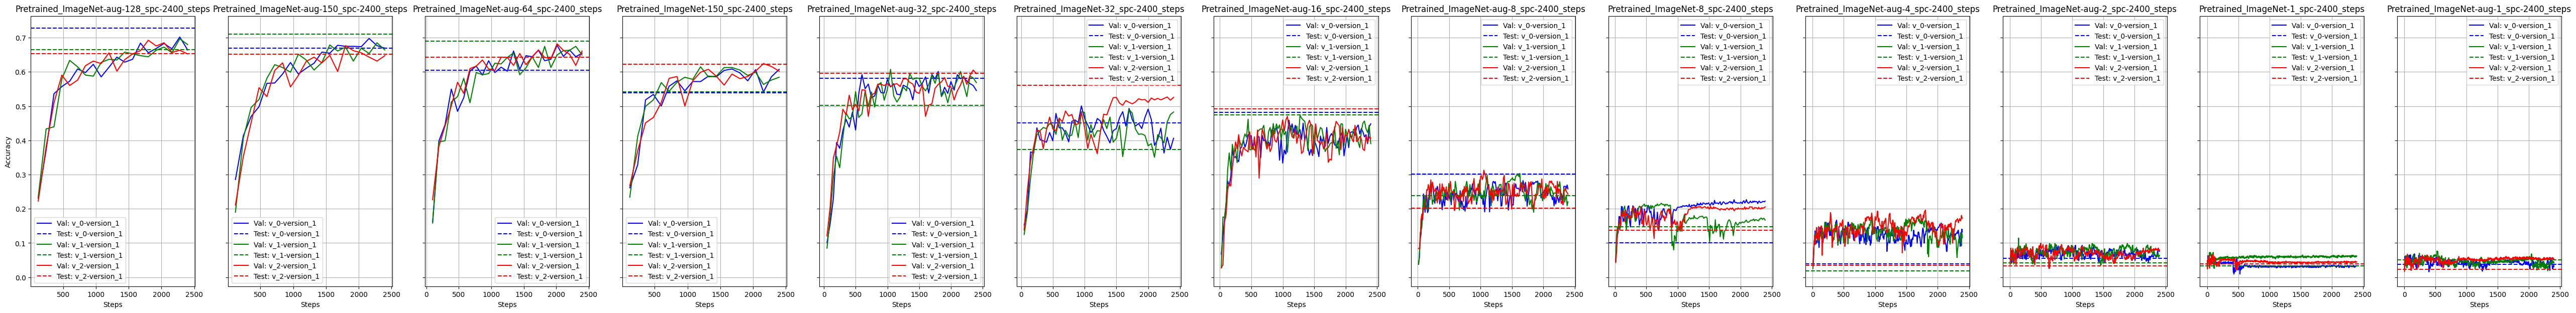

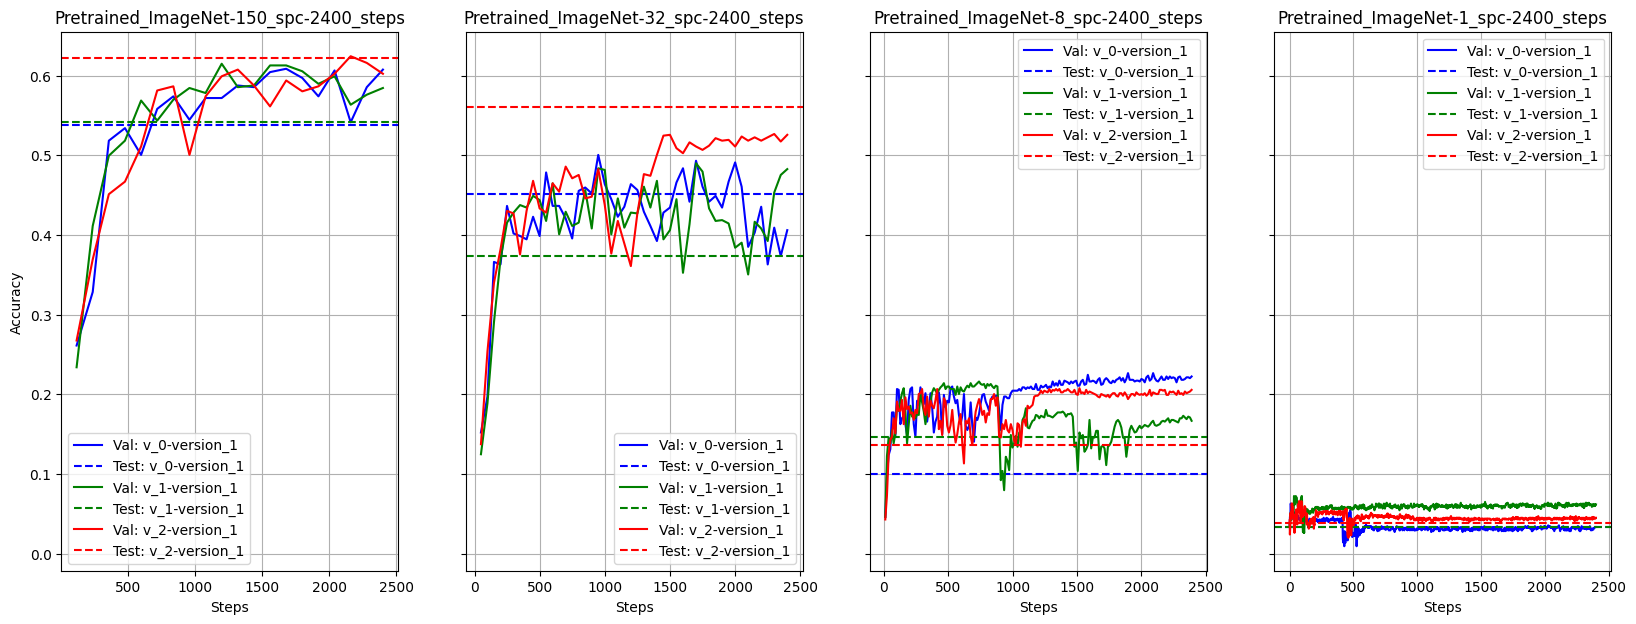

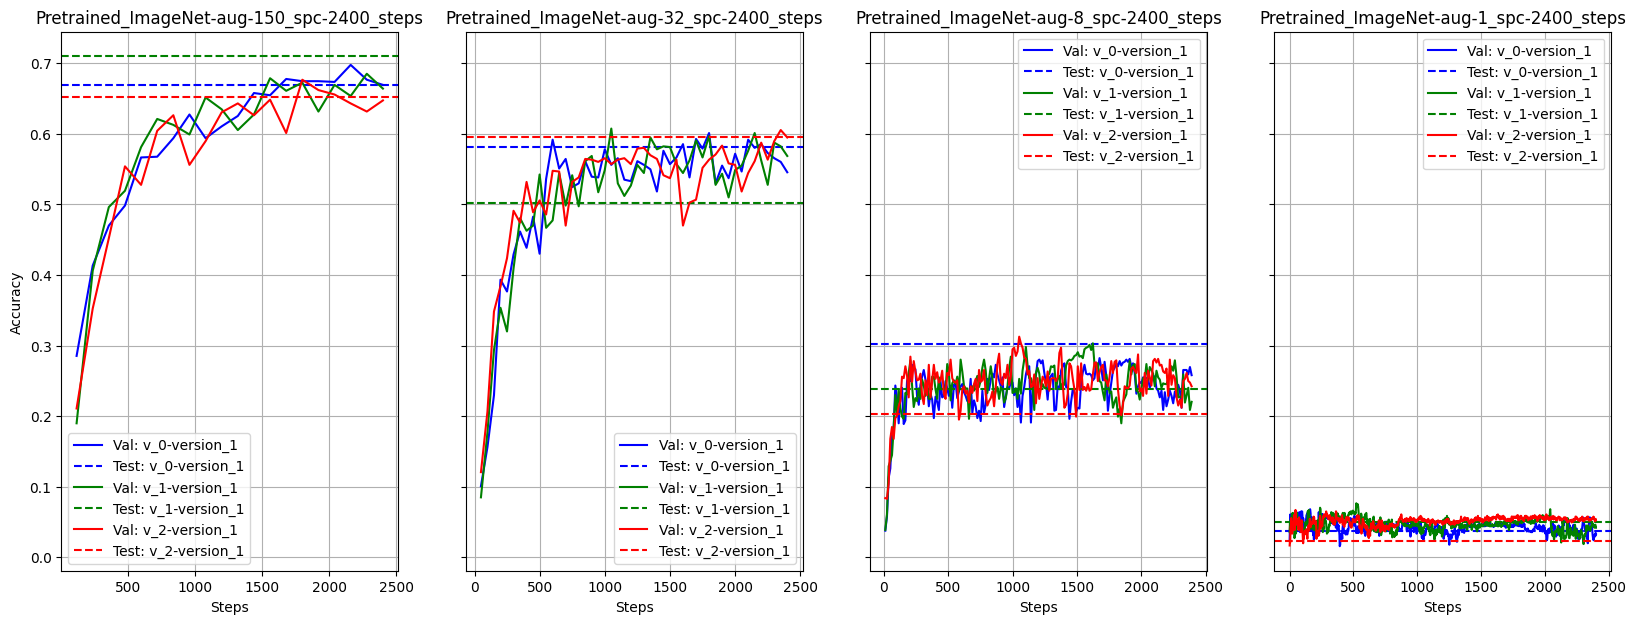

In [10]:

plot_results(sorted_list, stats)

plot_results(sorted_list=["Pretrained_ImageNet-150_spc-2400_steps", 
                          "Pretrained_ImageNet-32_spc-2400_steps", 
                          "Pretrained_ImageNet-8_spc-2400_steps",
                          "Pretrained_ImageNet-1_spc-2400_steps"], stats=stats)

plot_results(sorted_list=["Pretrained_ImageNet-aug-150_spc-2400_steps", 
                          "Pretrained_ImageNet-aug-32_spc-2400_steps", 
                          "Pretrained_ImageNet-aug-8_spc-2400_steps",
                          "Pretrained_ImageNet-aug-1_spc-2400_steps"], stats=stats)
                          